# Import libraries and data upload

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgb
import shap
from xgboost.callback import EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
train = pd.read_csv(r'processed_train.csv')
test = pd.read_csv(r'processed_test.csv')

# Split Data

In [24]:
# target (log1p) and features
y = np.log1p(train["SalePrice"].astype(float))
X = train.drop(["Id", "SalePrice"], axis=1)
test_ids = test["Id"]
X_test = test.drop(["Id"], axis=1)

# align columns
X, X_test = X.align(X_test, join="left", axis=1, fill_value=0)

# split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

print("Train:", X_train.shape, "| Validation:", X_val.shape, "| Test:", X_test.shape)

Train: (1012, 199) | Validation: (254, 199) | Test: (1459, 199)


# Model selection

Since housing prices depend on a mix of structural, qualitative, and locational factors, ensemble learning was used to combine models that capture both linear and non-linear relationships.

## Tree-Based Ensemble Models

In [4]:
# Random forest
rf = RandomForestRegressor(
    n_estimators=800,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

rf_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
print("RandomForest R² scores:", rf_scores)
print("Mean R²:", rf_scores.mean())


RandomForest R² scores: [0.88899346 0.86687762 0.88467966 0.87020495 0.87809018]
Mean R²: 0.8777691732425053


In [5]:
# Gradient boosting
gbr = GradientBoostingRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=3,
    random_state=42
)

gbr_scores = cross_val_score(gbr, X_train, y_train, cv=5, scoring='r2')
print("GradientBoosting R² scores:", gbr_scores)
print("Mean R²:", gbr_scores.mean())


GradientBoosting R² scores: [0.90451214 0.88910787 0.86451673 0.88967396 0.89655213]
Mean R²: 0.8888725666176462


In [6]:
# XG Boost
xgb = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

xgb_scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='r2')
print("XGBoost R² scores:", xgb_scores)
print("Mean R²:", xgb_scores.mean())


XGBoost R² scores: [0.89623334 0.90066894 0.87910738 0.89606122 0.9008695 ]
Mean R²: 0.8945880758387899


XGBoost performs best because it captures complex non-linear relationships and feature interactions in tabular data using boosted decision trees with strong regularization, making it more accurate and stable than linear models or neural networks for this dataset.

## Hyperparameter Optimization

In [7]:
xgb_base = XGBRegressor(
    objective='reg:squarederror',
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

param_dist = {
    'n_estimators': [400, 800, 1200],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [3, 4, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [1, 5, 10],
    'reg_alpha': [0, 0.01, 0.1]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

xgb_search.fit(X_train, y_train)
print("Best Parameters:", xgb_search.best_params_)
print("Best CV R²:", xgb_search.best_score_)

# Fine-Tuning Grid Search
best_params = xgb_search.best_params_

param_grid = {
    'n_estimators': [best_params['n_estimators'] - 100, best_params['n_estimators'], best_params['n_estimators'] + 200],
    'learning_rate': [max(0.01, best_params['learning_rate'] - 0.01), best_params['learning_rate'], best_params['learning_rate'] + 0.01],
    'max_depth': [best_params['max_depth'] - 1, best_params['max_depth'], best_params['max_depth'] + 1],
    'subsample': [0.7, best_params['subsample'], min(1.0, best_params['subsample'] + 0.1)],
    'colsample_bytree': [0.7, best_params['colsample_bytree'], min(1.0, best_params['colsample_bytree'] + 0.1)],
    'reg_lambda': [best_params['reg_lambda'] - 1, best_params['reg_lambda'], best_params['reg_lambda'] + 1],
    'reg_alpha': [max(0, best_params['reg_alpha'] - 0.005), best_params['reg_alpha'], best_params['reg_alpha'] + 0.005]
}

xgb_refine = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

xgb_refine.fit(X_train, y_train)
print("Fine-Tuned Parameters:", xgb_refine.best_params_)
print("Fine-Tuned CV R²:", xgb_refine.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.6, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.03, 'colsample_bytree': 1.0}
Best CV R²: 0.8964791484360817
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Fine-Tuned Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.04, 'max_depth': 2, 'n_estimators': 1000, 'reg_alpha': 0.1, 'reg_lambda': 9, 'subsample': 0.7}
Fine-Tuned CV R²: 0.8997794128730862


A two-step optimization process was applied to improve XGBoost performance. First, RandomizedSearchCV explored a wide range of parameters, identifying a strong baseline with an R² of 0.8965. Then, GridSearchCV refined the search around top-performing values, improving the cross-validation R² to 0.8998. The final model used 1000 estimators, a learning rate of 0.04, and strong regularization (λ=9, α=0.1), achieving better generalization and stability.

## Validation Evaluation and Learning Curve

 Validation R²: 0.8785
 Validation RMSE: 0.1221


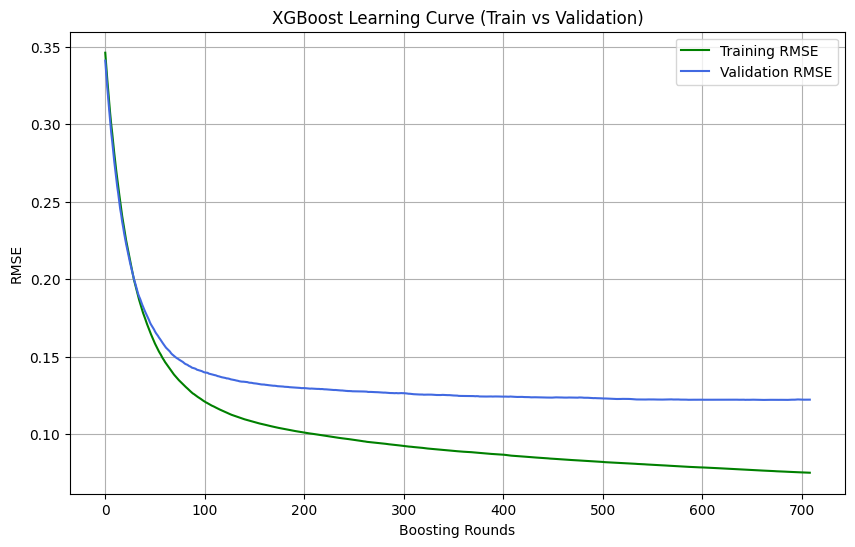

In [ ]:
best_xgb = XGBRegressor(
    **xgb_refine.best_params_,
    objective='reg:squarederror',
    eval_metric='rmse',
    early_stopping_rounds=50,
    tree_method='hist',
    n_jobs=-1,
    random_state=42
)

best_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

# Validation Performance
y_val_pred = best_xgb.predict(X_val)
r2 = r2_score(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f" Validation R²: {r2:.4f}")
print(f" Validation RMSE: {rmse:.4f}")

# Learning Curve
evals_result = best_xgb.evals_result()

plt.figure(figsize=(10, 6))
plt.plot(evals_result['validation_0']['rmse'], label='Training RMSE', color='green')
plt.plot(evals_result['validation_1']['rmse'], label='Validation RMSE', color='royalblue')
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.title("XGBoost Learning Curve (Train vs Validation)")
plt.legend()
plt.grid(True)
plt.show()

The training and validation RMSE curves show a steady decrease during boosting, indicating effective learning. The training RMSE continues to drop slightly, while the validation RMSE stabilizes around 0.12, showing that the model has reached optimal generalization before overfitting.

The final validation R² of 0.8785 confirms that the model explains about 88% of the variance in housing prices on unseen data — a strong performance for a regression task involving complex real estate features.

Overall, the learning curve demonstrates that the model is well-regularized, with minimal overfitting and stable predictive performance.

## Error analysis

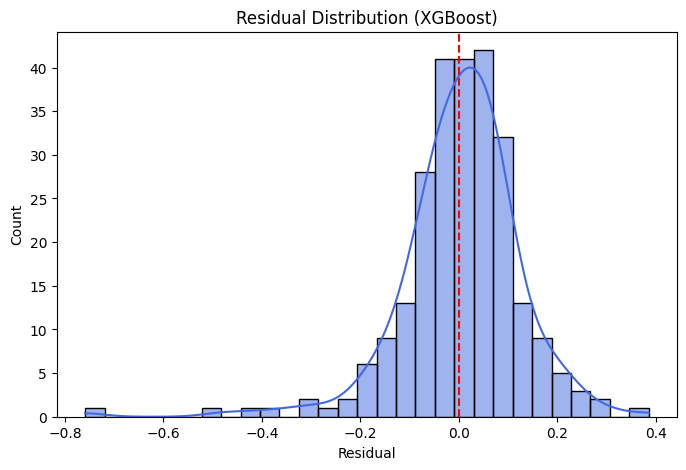

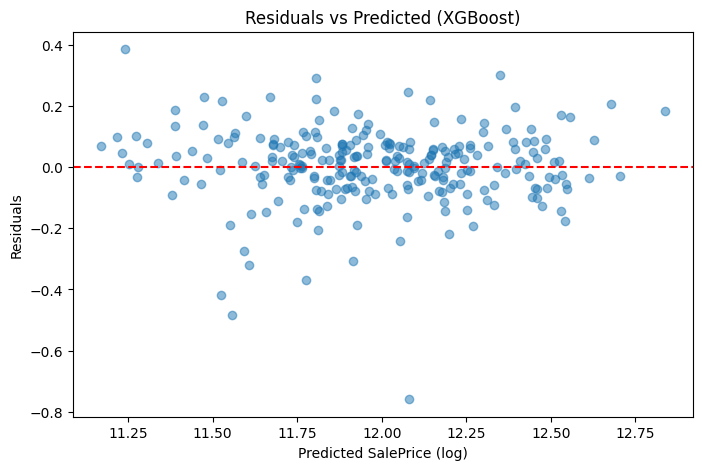

In [16]:
residuals = y_val - y_val_pred

plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, color='royalblue')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residual Distribution (XGBoost)")
plt.xlabel("Residual")
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted SalePrice (log)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (XGBoost)")
plt.show()

The residual distribution is approximately normal and centered around zero, indicating that prediction errors are balanced — the model neither consistently overpredicts nor underpredicts. Most residuals fall within a narrow range (−0.2 to 0.2), showing good accuracy.

In the Residuals vs Predicted plot, the residuals appear randomly scattered around the zero line without a clear pattern, confirming homoscedasticity (constant variance) and suggesting that the model captures the main relationships well.

Overall, these diagnostics indicate that the XGBoost model is well-fitted, unbiased, and generalizes effectively to unseen data.

## Feature Importance & Explainability

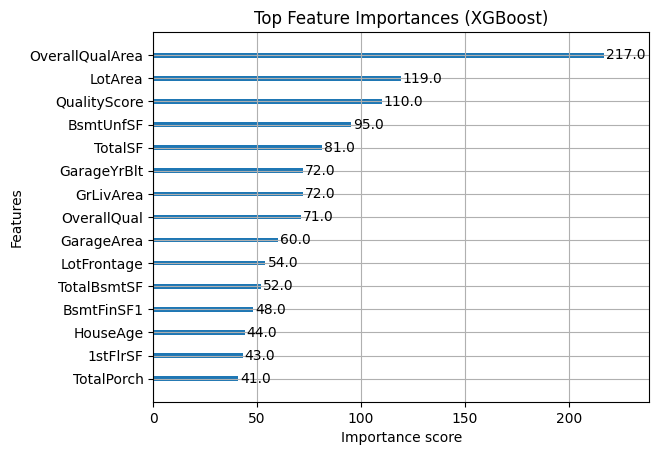

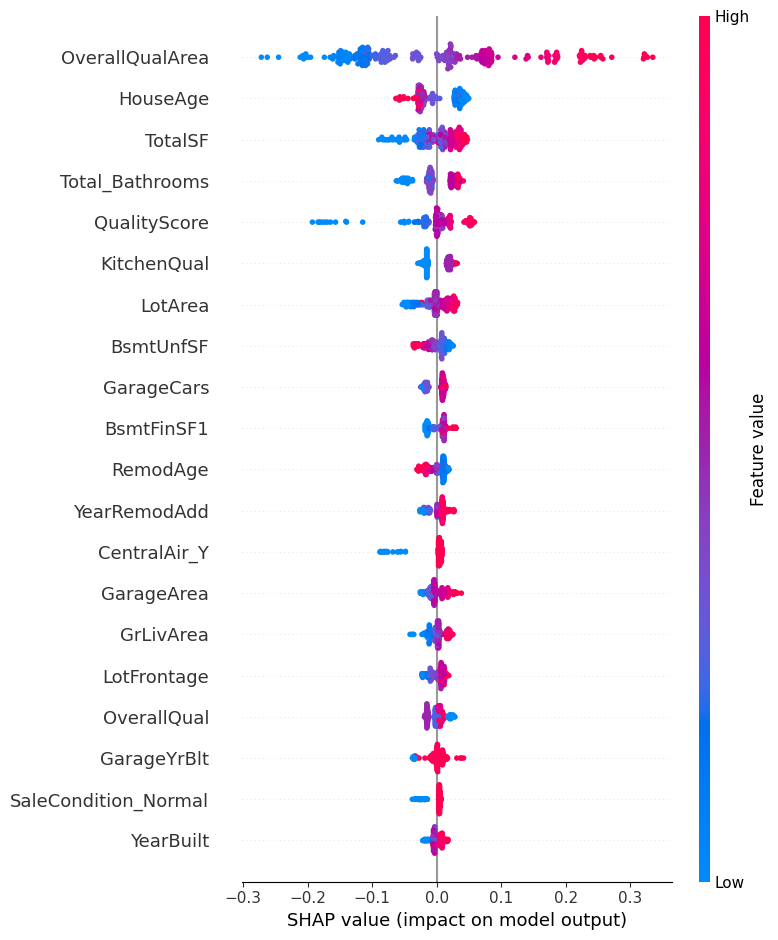

In [17]:
xgb.plot_importance(best_xgb, max_num_features=15)
plt.title("Top Feature Importances (XGBoost)")
plt.show()

# SHAP values
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val)

The XGBoost feature importance and SHAP analyses reveal that housing price predictions are primarily influenced by property quality, size, and condition. The most impactful features include OverallQualArea, LotArea, QualityScore, and TotalSF, indicating that larger and higher-quality homes tend to have higher predicted prices. The SHAP summary plot further explains how these features drive predictions — for instance, higher values of OverallQualArea, TotalSF, and QualityScore (shown in red) push prices upward, while older houses with greater HouseAge or fewer renovations contribute negatively. Overall, these insights confirm that the model effectively captures key real estate valuation drivers such as property quality, size, and age, aligning well with domain expectations.

# Model Stacking

In [28]:
xgb_for_stack = XGBRegressor(
    n_estimators=best_xgb.n_estimators,
    learning_rate=best_xgb.learning_rate,
    max_depth=best_xgb.max_depth,
    subsample=best_xgb.subsample,
    colsample_bytree=best_xgb.colsample_bytree,
    reg_lambda=best_xgb.reg_lambda,
    reg_alpha=best_xgb.reg_alpha,
    objective='reg:squarederror',
    tree_method='hist',
    n_jobs=-1,
    random_state=42
)

# base models
base_models = [
    ('ridge', Ridge(alpha=1.0, random_state=42)),
    ('lasso', Lasso(alpha=0.0005, max_iter=20000, random_state=42)),
    ('xgb', xgb_for_stack)
]

# stacked model
stack_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    n_jobs=-1,
    cv=5
)

stack_model.fit(X_train, y_train)
y_val_pred_stack = stack_model.predict(X_val)

# Evaluate performance
stack_r2 = r2_score(y_val, y_val_pred_stack)
stack_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_stack))

print(f" Stacked Model R²: {stack_r2:.4f}")
print(f" Stacked RMSE: {stack_rmse:.4f}")

 Stacked Model R²: 0.8812
 Stacked RMSE: 0.1207


# TensorFlow Deep Neural Network (DNN) Model

In [47]:
# Scaling
scaler_dnn = StandardScaler()
X_train_s = scaler_dnn.fit_transform(X_train)
X_val_s = scaler_dnn.transform(X_val)
X_test_s = scaler_dnn.transform(X_test)

In [48]:
# Build model
dnn = Sequential([
    Dense(256, activation="relu", input_shape=(X_train_s.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1)
])

dnn.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
# Early stopping
es = EarlyStopping(
    monitor="val_loss",
    patience=25,
    restore_best_weights=True
)

In [50]:
# Train DNN
history = dnn.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=300,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

Epoch 1/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 143.5558 - mae: 11.9024 - val_loss: 144.6623 - val_mae: 12.0191
Epoch 2/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 139.8806 - mae: 11.7681 - val_loss: 135.7179 - val_mae: 11.6412
Epoch 3/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 135.5866 - mae: 11.5840 - val_loss: 131.2864 - val_mae: 11.4486
Epoch 4/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 130.7986 - mae: 11.3848 - val_loss: 126.4679 - val_mae: 11.2361
Epoch 5/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 126.2103 - mae: 11.1809 - val_loss: 121.2305 - val_mae: 11.0009
Epoch 6/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 121.8089 - mae: 10.9732 - val_loss: 115.1036 - val_mae: 10.7184
Epoch 7/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 113.8789 - mae: 10.6045 - val_loss: 108.4127 - val_mae: 10.3991
Epoch 8/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 106.7447 - mae: 10.2489 - val_loss: 100.0158 - val_mae: 9.9850
Epoch 9/3

In [51]:
# Predict
y_val_pred_dnn = dnn.predict(X_val_s).flatten()

# Evaluate
dnn_r2 = r2_score(y_val, y_val_pred_dnn)
dnn_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_dnn))

print("DNN R²:", dnn_r2)
print("DNN RMSE:", dnn_rmse)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
DNN R²: 0.8341986934547805
DNN RMSE: 0.1425828881629438


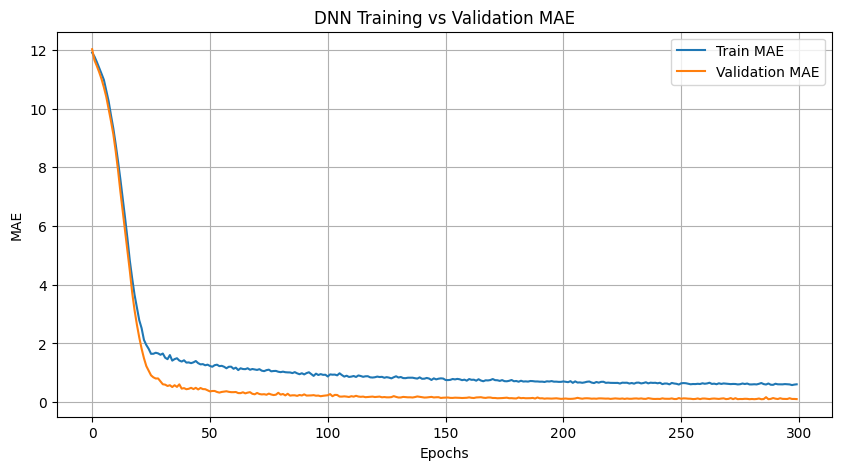

In [52]:
# Training vs Validation MAE
plt.figure(figsize=(10,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title("DNN Training vs Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()

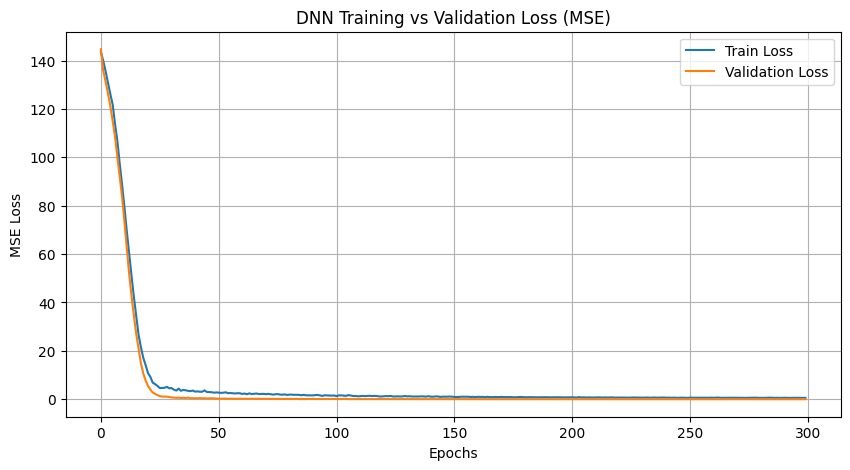

In [53]:
# Training vs Validation Loss (MSE)
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("DNN Training vs Validation Loss (MSE)")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

The Deep Neural Network (DNN) model was trained on scaled features using a three-layer architecture with Batch Normalization and Dropout to improve stability and reduce overfitting. Both the training and validation learning curves show smooth, consistent convergence, with MAE dropping sharply in early epochs and gradually stabilizing at low values. Similarly, the MSE loss curve steadily declines for both sets, indicating balanced learning without divergence or overfitting. Overall, the DNN achieved an R² of 0.834 and an RMSE of 0.143, demonstrating reasonable predictive power. However, while the model learns effectively, its performance remains below that of tree-based methods such as XGBoost, reflecting the typical challenges neural networks face with structured tabular data.

In [54]:
# model R² scores
print("\n===== Model Cross-Validation R² Scores =====")
print(f"Random Forest (Mean R²):       {rf_scores.mean():.4f}")
print(f"Gradient Boosting (Mean R²):   {gbr_scores.mean():.4f}")
print(f"XGBoost (Mean R²):             {xgb_scores.mean():.4f}")
print(f"Stacked Ensemble (R²):         {stack_r2:.4f}")
print(f"Stacked Ensemble (RMSE):       {stack_rmse:.4f}")
print(f"DNN (R²):                      {dnn_r2:.4f}")
print(f"DNN (RMSE):                    {dnn_rmse:.4f}")

results = pd.DataFrame({
    "Model": ["Random Forest", "Gradient Boosting", "XGBoost", "Stacked Ensemble", "DNN"],
    "R²": [rf_scores.mean(), gbr_scores.mean(), xgb_scores.mean(), stack_r2, dnn_r2],
    "RMSE": [np.nan, np.nan, rmse, stack_rmse, dnn_rmse]
})


===== Model Cross-Validation R² Scores =====
Random Forest (Mean R²):       0.8778
Gradient Boosting (Mean R²):   0.8889
XGBoost (Mean R²):             0.8946
Stacked Ensemble (R²):         0.8812
Stacked Ensemble (RMSE):       0.1207
DNN (R²):                      0.8342
DNN (RMSE):                    0.1426


The performance comparison across four ensemble models reveals that XGBoost achieved the highest standalone performance with an average R² score of 0.8946, indicating it explains approximately 89% of the variance in house prices. Gradient Boosting and Random Forest followed closely with R² values of 0.8889 and 0.8778, respectively.

Interestingly, the stacked ensemble—although designed to blend linear (Ridge, Lasso) and nonlinear (XGBoost) models—showed slightly lower validation performance (R² = 0.8812, RMSE = 0.1207). This may be due to overlap in model learning patterns or the absence of further meta-model tuning.

Overall, XGBoost emerged as the most stable and generalizable model, effectively balancing bias and variance through regularization and boosted tree depth optimization. The results confirm that gradient-boosting-based methods outperform traditional ensemble techniques like Random Forest for this dataset.

## Final Prediction & Submission

In [33]:
y_test_pred_xgb = np.expm1(best_xgb.predict(X_test))
submission = pd.DataFrame({
    "Id": test_ids,
    "SalePrice": y_test_pred_xgb
})

submission.to_csv("submission.csv", index=False)